# Capstone Project: AI-Based Prediction of Road Accidents and Road Rage Using Traffic Data

**Overview**: This capstone project aims to use machine learning to predict the likelihood and severity of road accidents and identify risk factors for road rage in a specific state, such as California. By analyzing public traffic and crash data, the project will develop predictive models and conduct spatial and time-based analyses to pinpoint high-risk areas and conditions. The findings will be used to provide actionable recommendations for state agencies, helping them improve road safety through targeted interventions, better resource allocation, and focused campaigns against dangerous driving. Ultimately, the project will demonstrate how data science can help address major transportation safety challenges


### Getting Started

The analysis will utilize the US Accidents dataset from Kaggle [US Accidents (2016 - 2023)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents), filtered by state (such as California, Texas, or another of interest) alongside accident data,[Registered Vehicles](https://data.transportation.gov/Roadways-and-Bridges/Motor-Vehicle-Registrations-1900-2023-MV-1-wide-fo/hwtm-7xmz/about_data) and [Registered Drivers](https://data.transportation.gov/d/xfkb-3bxx
) data is used. The accident dataset contains millions of accident records across the US, but the analysis will be limited to one chosen state for computational feasibility and model relevance. 


**Note:** This notebook is next phase after Exploratory Data Analysis (EDA), refere to [anaysis.ipynb](https://github.com/hemant280/berkely-ai-ml-capstone/blob/main/analysis.ipynb) for data analysis steps and how features are generated, the [final_accidents_vehicles_drivers_ca](https://github.com/hemant280/berkeley-ai-ml-capstone/blob/main/data/final_accidents_vehicles_drivers_ca.csv) is generated by analysis notebook.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, StandardScaler



In [79]:
# Read the dataset file final_accidents_vehicles_drivers_df generated by EDA analysis notebook
eda_df = pd.read_csv('data/final_accidents_vehicles_drivers_ca.csv')

In [80]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741433 entries, 0 to 1741432
Data columns (total 25 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Severity                   int64  
 1   Temperature(F)             float64
 2   Humidity(%)                float64
 3   Pressure(in)               float64
 4   Visibility(mi)             float64
 5   Wind_Speed(mph)            float64
 6   Amenity                    int64  
 7   Bump                       int64  
 8   Crossing                   int64  
 9   Give_Way                   int64  
 10  Junction                   int64  
 11  No_Exit                    int64  
 12  Railway                    int64  
 13  Roundabout                 int64  
 14  Station                    int64  
 15  Stop                       int64  
 16  Traffic_Calming            int64  
 17  Traffic_Signal             int64  
 18  Start_Year                 int64  
 19  Impact_Duration_HR         float64
 20  To

In [81]:
# Convert the Start_Time_TS datetime format and extract useful features
eda_df['Start_Time_TS'] = pd.to_datetime(eda_df['Start_Time_TS'], errors='coerce')
eda_df["Start_Month"] = eda_df["Start_Time_TS"].dt.month
eda_df["Start_Day"] = eda_df["Start_Time_TS"].dt.day
eda_df["Start_Weekday"] = eda_df["Start_Time_TS"].dt.weekday  # Monday=0, Sunday=6
eda_df["Start_Hour"] = eda_df["Start_Time_TS"].dt.hour
eda_df["Start_Minute"] = eda_df["Start_Time_TS"].dt.minute
eda_df["Start_Is_Weekend"] = (eda_df["Start_Time_TS"].dt.weekday >= 5).astype(int)
# Dropping the original Start_Time_TS column
eda_df = eda_df.drop(columns=['Start_Time_TS'])
# Dropping End_Time_TS column as we have Start_Time_TS and Duration
eda_df = eda_df.drop(columns=['End_Time_TS'])

In [82]:

feature_df = eda_df.drop(["Severity"], axis=1)
target_df = pd.DataFrame(eda_df["Severity"], columns=["Severity"])
target_df = target_df.reset_index(drop=True)
feature_df.info()
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741433 entries, 0 to 1741432
Data columns (total 28 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Temperature(F)             float64
 1   Humidity(%)                float64
 2   Pressure(in)               float64
 3   Visibility(mi)             float64
 4   Wind_Speed(mph)            float64
 5   Amenity                    int64  
 6   Bump                       int64  
 7   Crossing                   int64  
 8   Give_Way                   int64  
 9   Junction                   int64  
 10  No_Exit                    int64  
 11  Railway                    int64  
 12  Roundabout                 int64  
 13  Station                    int64  
 14  Stop                       int64  
 15  Traffic_Calming            int64  
 16  Traffic_Signal             int64  
 17  Start_Year                 int64  
 18  Impact_Duration_HR         float64
 19  Total_Vehicles             int64  
 20  To

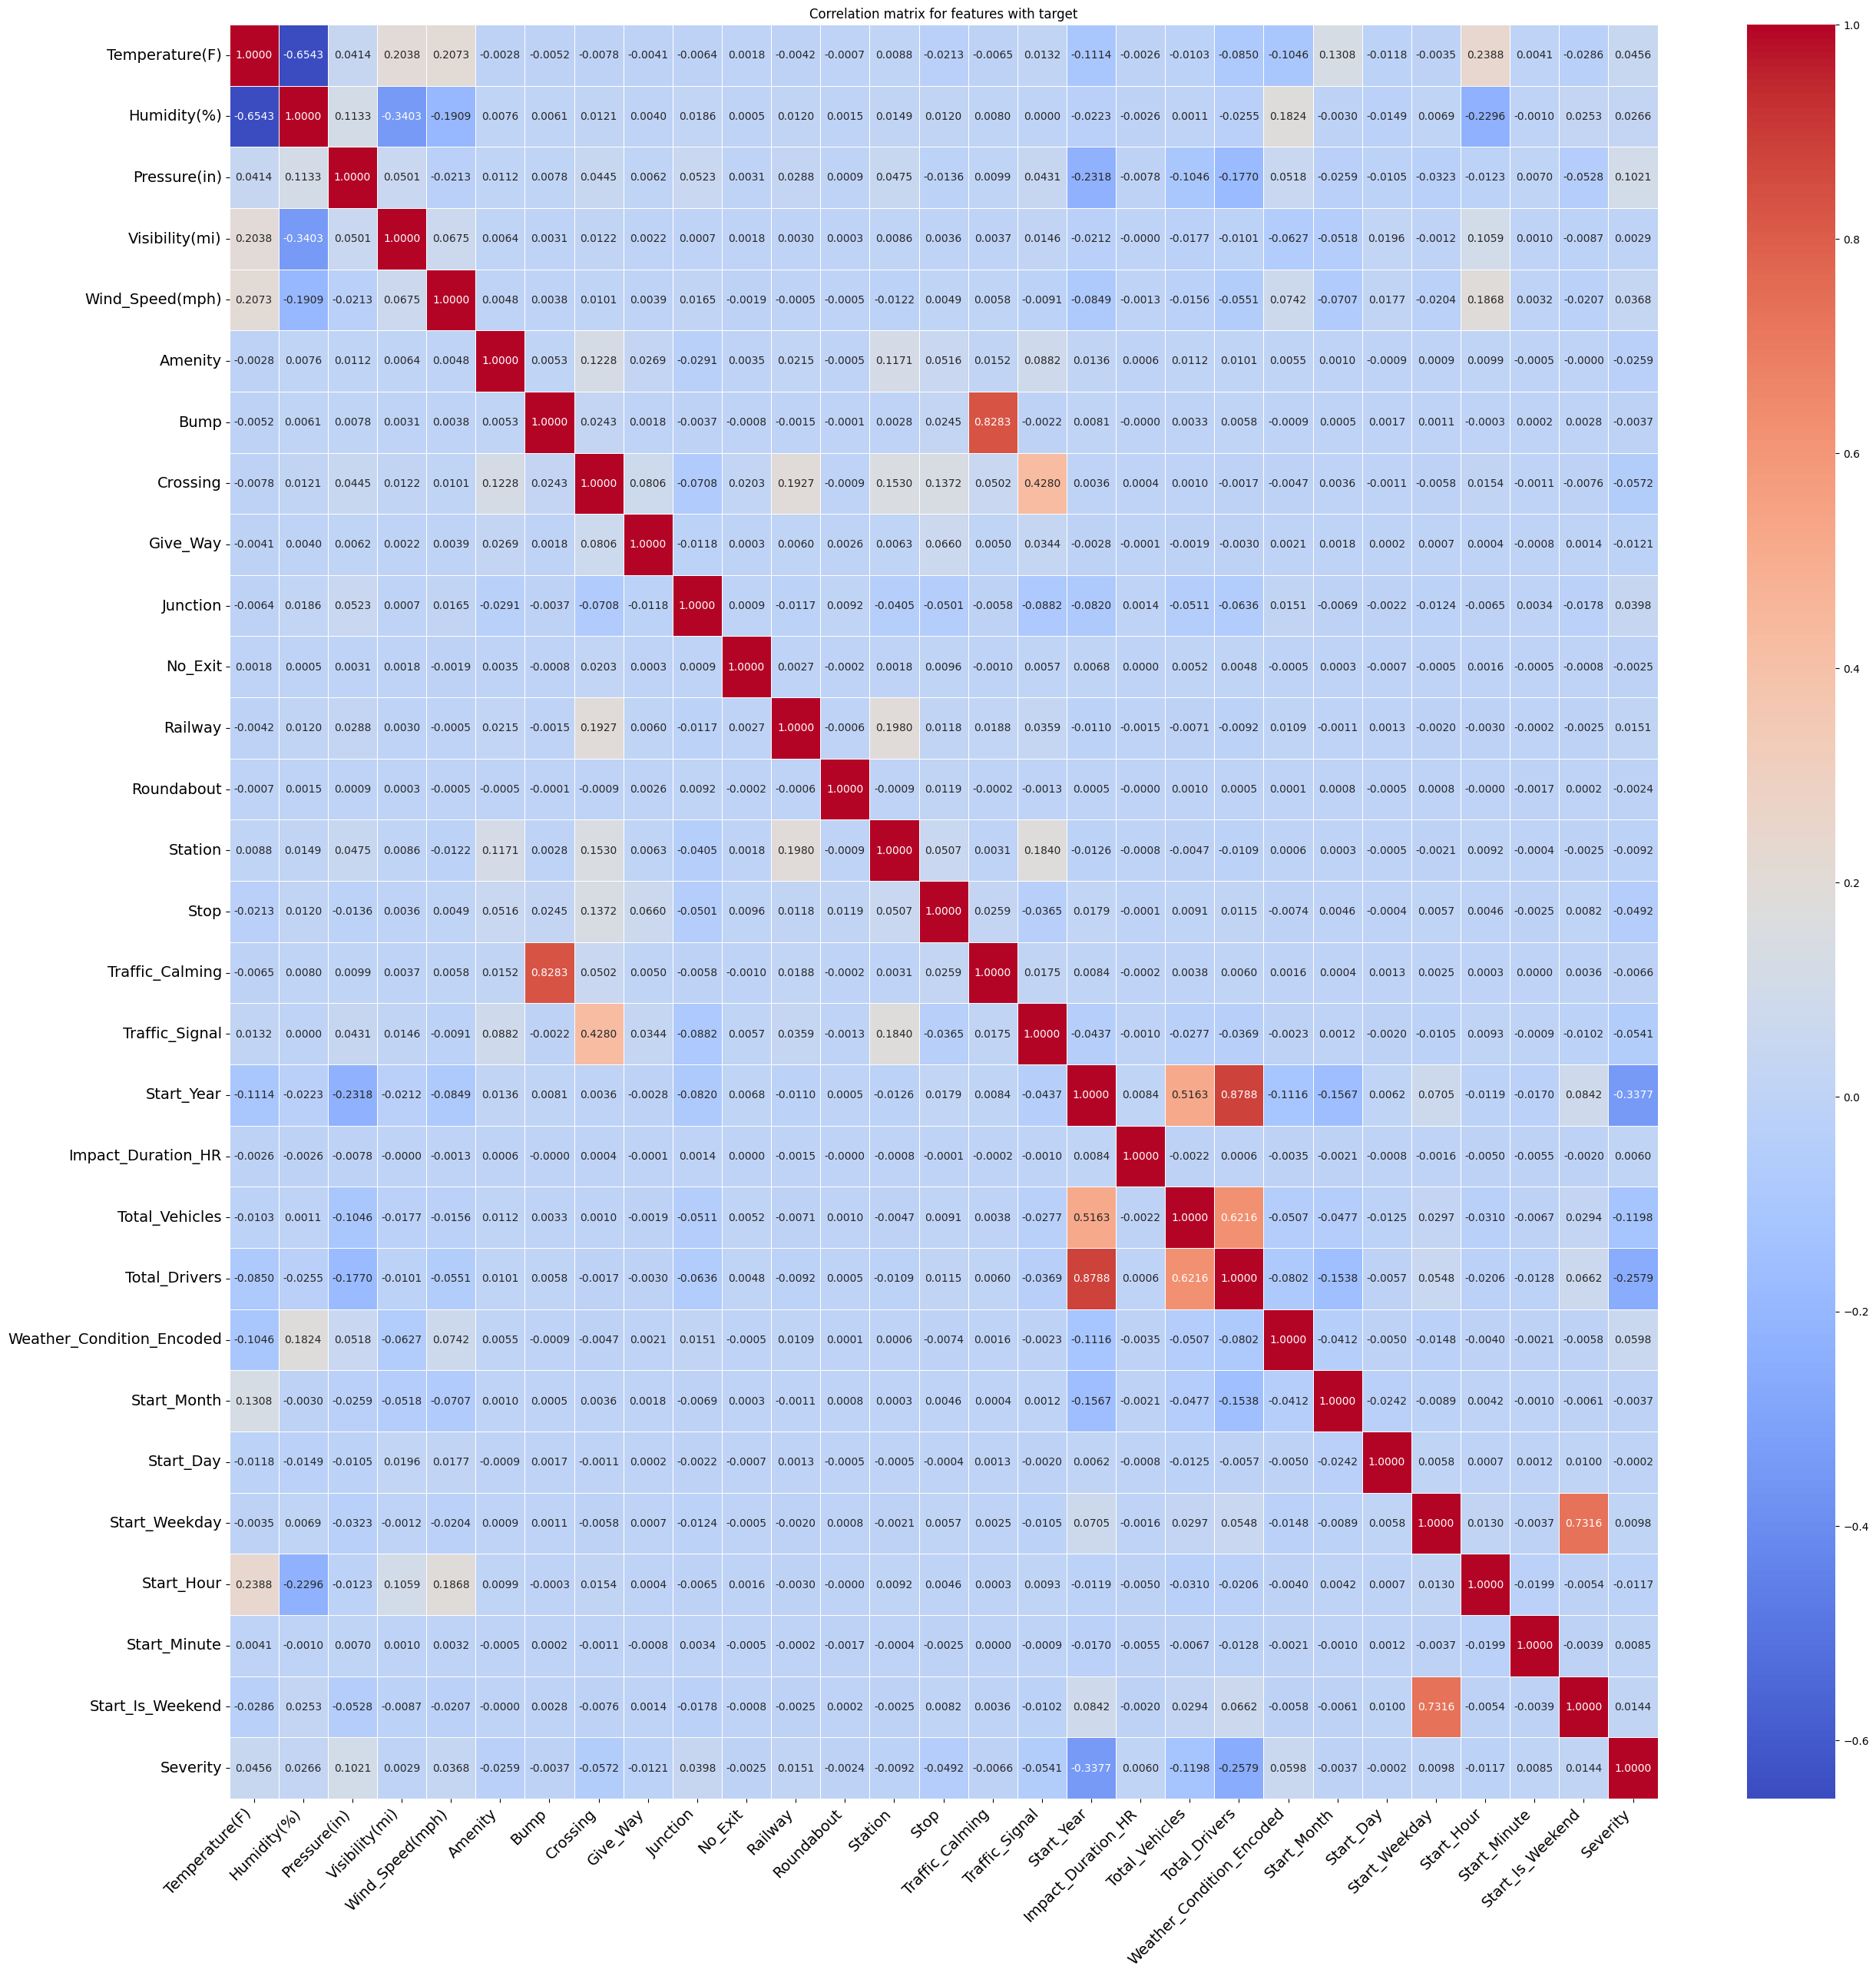

In [83]:
correlation_mat = pd.concat([feature_df, target_df], axis=1).corr()
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(correlation_mat, cmap="coolwarm", fmt=".4f", linewidths=0.5, annot=True)
# Get and set the font size for the axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14, ha="right")

plt.title("Correlation matrix for features with target")
plt.show()

In [84]:
# Indentify highly correlated features
threshold = 0.8
high_corr_pairs = []
for i in range(len(correlation_mat.columns)):
    for j in range(i):
        if abs(correlation_mat.iloc[i, j]) > threshold and correlation_mat.columns[i] != correlation_mat.columns[j]:
            high_corr_pairs.append((correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i, j]))
high_corr_pairs

[('Traffic_Calming', 'Bump', 0.8283131572976505),
 ('Total_Drivers', 'Start_Year', 0.8788168356080253)]

Removing highly correlated features
- Remove 
    - Start_Year 
    - Traffic_Calming


In [85]:
# Remove highly correlated features
# - Keep Start_Time_TS as it is highly correlated with End_Time_TS and also it is more relevant for modeling
feature_df.drop(columns=[ "Start_Year", "Traffic_Calming"], errors="ignore")

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,Crossing,Give_Way,Junction,...,Impact_Duration_HR,Total_Vehicles,Total_Drivers,Weather_Condition_Encoded,Start_Month,Start_Day,Start_Weekday,Start_Hour,Start_Minute,Start_Is_Weekend
0,75.0,48.0,30.00,10.0,5.8,0,0,0,0,0,...,0.30,30221033,26199436,4,6,21,1,10,34,0
1,75.0,48.0,30.06,10.0,4.6,0,0,0,0,0,...,0.46,30221033,26199436,4,6,21,1,10,30,0
2,82.9,31.0,29.97,10.0,4.6,0,0,0,0,0,...,0.30,30221033,26199436,4,6,21,1,10,49,0
3,75.9,48.0,30.04,10.0,4.6,0,0,0,0,0,...,0.30,30221033,26199436,4,6,21,1,10,41,0
4,75.2,41.0,30.06,10.0,5.8,0,0,0,0,0,...,0.47,30221033,26199436,4,6,21,1,10,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741428,86.0,40.0,28.92,10.0,13.0,0,0,0,0,0,...,0.28,31247269,27213650,11,8,23,4,18,3,0
1741429,70.0,73.0,29.39,10.0,6.0,0,0,0,0,0,...,0.26,31247269,27213650,11,8,23,4,19,11,0
1741430,73.0,64.0,29.74,10.0,10.0,0,0,0,0,1,...,0.28,31247269,27213650,54,8,23,4,19,0,0
1741431,71.0,81.0,29.62,10.0,8.0,0,0,0,0,0,...,0.29,31247269,27213650,11,8,23,4,19,0,0


In [86]:
feature_df.describe()

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,Crossing,Give_Way,Junction,...,Impact_Duration_HR,Total_Vehicles,Total_Drivers,Weather_Condition_Encoded,Start_Month,Start_Day,Start_Weekday,Start_Hour,Start_Minute,Start_Is_Weekend
count,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,...,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06,1.741433e+06
mean,6.387668e+01,5.877727e+01,2.963615e+01,9.110170e+00,6.499429e+00,7.481195e-03,5.891700e-04,5.309191e-02,1.262179e-03,1.066099e-01,...,1.814399e+00,3.094956e+07,2.713683e+07,2.136214e+01,6.602168e+00,1.575048e+01,2.761066e+00,1.245132e+01,2.991323e+01,2.052798e-01
std,1.341139e+01,2.387920e+01,7.686433e-01,2.496440e+00,5.429370e+00,8.616978e-02,2.426568e-02,2.242168e-01,3.550474e-02,3.086167e-01,...,2.362506e+01,3.796217e+05,3.942059e+05,2.076065e+01,3.650297e+00,8.720700e+00,1.875777e+00,5.775850e+00,1.722640e+01,4.039060e-01
min,-2.990000e+01,1.000000e+00,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.000000e-02,3.022103e+07,2.619944e+07,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.500000e+01,4.100000e+01,2.963000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.300000e-01,3.079514e+07,2.700530e+07,1.100000e+01,3.000000e+00,8.000000e+00,1.000000e+00,8.000000e+00,1.500000e+01,0.000000e+00
50%,6.300000e+01,6.100000e+01,2.986000e+01,1.000000e+01,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.160000e+00,3.111911e+07,2.711260e+07,1.100000e+01,7.000000e+00,1.600000e+01,3.000000e+00,1.300000e+01,3.000000e+01,0.000000e+00
75%,7.200000e+01,7.800000e+01,2.999000e+01,1.000000e+01,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.100000e+00,3.124727e+07,2.763210e+07,3.400000e+01,1.000000e+01,2.300000e+01,4.000000e+00,1.700000e+01,4.500000e+01,0.000000e+00
max,2.070000e+02,1.000000e+02,5.839000e+01,1.400000e+02,1.087000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.052156e+04,3.134907e+07,2.774235e+07,8.700000e+01,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,5.900000e+01,1.000000e+00


In [87]:
# final check to ensure no missing values
print("Missing values in target_df:", feature_df.isnull().sum().sum())
print("Missing values in target_df:", target_df.isnull().sum().sum())
print("Shape for feature_df:", feature_df.shape)
print("Shape for target_df:", target_df.shape)

Missing values in target_df: 0
Missing values in target_df: 0
Shape for feature_df: (1741433, 28)
Shape for target_df: (1741433, 1)


### PCA Analysis
We want to reduce the dimensionality, we will use Principal Component Analysis to get the principal components and reduce the dimensionality

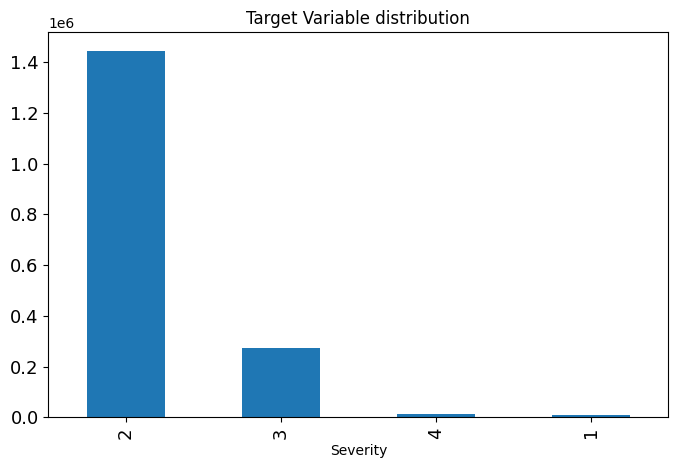

In [88]:
# Plotting the target variable distribution
target_df["Severity"].value_counts().plot(
    kind="bar", figsize=(8, 5), fontsize=13, title="Target Variable distribution"
)
plt.savefig("./images/target_variable_distribution.png")

Split the dataset for training and testing

In [89]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    feature_df, target_df, test_size=0.2, random_state=101
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1393146, 28), (348287, 28), (1393146, 1), (348287, 1))

In [90]:
def perform_pca_analysis(x_train, x_test, n_components=None):
    """
    Perform PCA analysis on the training and testing data.
    Standardize the data, perform PCA, and return the transformed data along with the PCA object.
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # Helper function to find the top features that contribute most to each principal component
    def get_top_features(loadings_df, n_features=5):
        top_features = {}
        for component in loadings_df.columns:
            sorted_features = loadings_df[component].abs().sort_values(ascending=False)
            top_features[component] = sorted_features.index[:n_features].tolist()
        return top_features

    # Standardize the data
    # standardize features before PCA, as it is sensitive to the scale of the data.
    random_seed = 42
    np.random.seed(random_seed)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.fit_transform(x_test)

    if not n_components:
        # Calculate the number of components to explain 95% variance
        # Perform PCA
        pca = PCA()
        pca.fit(x_train_scaled)
        # Calculate cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        # Find the number of components for 95% variance
        n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
        print(f"Number of components to capture 95% variance: {n_components}")
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.fit_transform(x_test_scaled)
    # Create a new DataFrame with the principal components
    column_names = [f"PC{i+1}" for i in range(x_train_pca.shape[1])]
    x_train_pca_df = pd.DataFrame(data=x_train_pca, columns=column_names)
    x_test_pca_df = pd.DataFrame(data=x_test_pca, columns=column_names)

    # Create a DataFrame for the loadings
    # The pca.components_ attribute needs to be transposed for clarity
    loadings_df = pd.DataFrame(
        pca.components_.T,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)],
        index=x_train.columns,
    )

    top_contributions = get_top_features(loadings_df)
    print("\nTop contributing features for each principal component:")
    for component, features in top_contributions.items():
        print(f"{component}: {features}")
    return x_train_pca_df, x_test_pca_df, pca

In [91]:
x_train_pca, x_test_pca, pca = perform_pca_analysis(x_train, x_test)

Number of components to capture 95% variance: 23

Top contributing features for each principal component:
PC1: ['Total_Drivers', 'Start_Year', 'Total_Vehicles', 'Pressure(in)', 'Temperature(F)']
PC2: ['Humidity(%)', 'Temperature(F)', 'Visibility(mi)', 'Start_Hour', 'Wind_Speed(mph)']
PC3: ['Traffic_Calming', 'Bump', 'Crossing', 'Traffic_Signal', 'Station']
PC4: ['Start_Weekday', 'Start_Is_Weekend', 'Crossing', 'Traffic_Signal', 'Station']
PC5: ['Start_Weekday', 'Start_Is_Weekend', 'Crossing', 'Traffic_Signal', 'Station']
PC6: ['Start_Month', 'Weather_Condition_Encoded', 'Wind_Speed(mph)', 'Start_Hour', 'Pressure(in)']
PC7: ['Stop', 'Give_Way', 'Pressure(in)', 'Railway', 'Junction']
PC8: ['Give_Way', 'Visibility(mi)', 'Stop', 'Pressure(in)', 'Start_Month']
PC9: ['Railway', 'Traffic_Signal', 'Station', 'Stop', 'Junction']
PC10: ['Start_Day', 'Impact_Duration_HR', 'Start_Minute', 'Pressure(in)', 'No_Exit']
PC11: ['Start_Minute', 'Impact_Duration_HR', 'Start_Day', 'Roundabout', 'Pressure(i

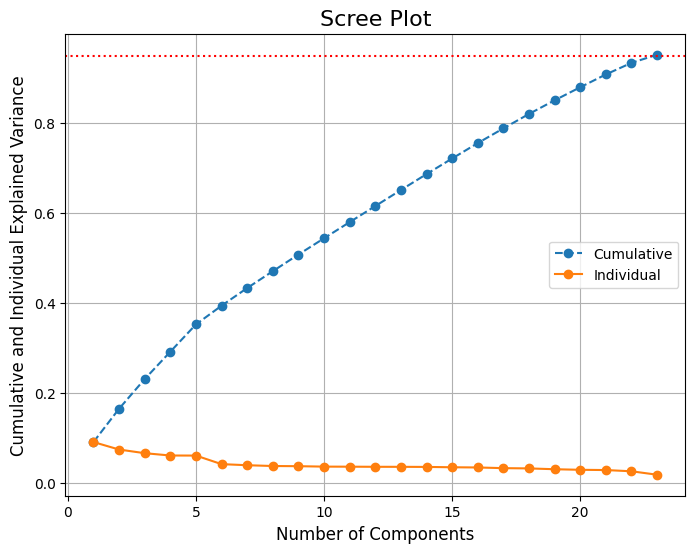

In [92]:
# Create the Scree Plot
plt.figure(figsize=(8, 6))
# Calculate the cumulative sum of the explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.plot(
    range(1, len(cumulative_variance) + 1),
    pca.explained_variance_ratio_,
    marker="o",
    linestyle="-",
)

plt.title("Scree Plot", fontsize=16)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative and Individual Explained Variance", fontsize=12)
plt.legend(["Cumulative", "Individual"], loc="best")
plt.grid(True)
plt.axhline(y=0.95, color="r", linestyle=":", label="95% Explained Variance")
plt.savefig("./images/pca_component_ratio.png")
plt.show()

We will limit the PCA to 6 components

In [93]:
x_train_pca, x_test_pca, pca = perform_pca_analysis(x_train, x_test,n_components=6)


Top contributing features for each principal component:
PC1: ['Total_Drivers', 'Start_Year', 'Total_Vehicles', 'Pressure(in)', 'Temperature(F)']
PC2: ['Humidity(%)', 'Temperature(F)', 'Visibility(mi)', 'Start_Hour', 'Wind_Speed(mph)']
PC3: ['Traffic_Calming', 'Bump', 'Crossing', 'Traffic_Signal', 'Station']
PC4: ['Start_Weekday', 'Start_Is_Weekend', 'Crossing', 'Traffic_Signal', 'Station']
PC5: ['Start_Weekday', 'Start_Is_Weekend', 'Crossing', 'Traffic_Signal', 'Station']
PC6: ['Start_Month', 'Weather_Condition_Encoded', 'Wind_Speed(mph)', 'Start_Hour', 'Pressure(in)']


#### Implement a Random Forest classifier

In [97]:
import os
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier

if os.path.exists('data/rf_model_ca.joblib'):
    rf_model = load('data/rf_model_ca.joblib')
else:
    # Initialize the Random Forest model
    # You can adjust hyperparameters like n_estimators (number of trees) for tuning
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model using the PCA-transformed training data
    rf_model.fit(x_train_pca, y_train.to_numpy().ravel())
    dump(rf_model, 'data/rf_model_ca.joblib', compress=('gzip', 3))

Evaluate the model

In [98]:
from sklearn.metrics import classification_report, accuracy_score
# Predict on the PCA-transformed test data
y_pred = rf_model.predict(x_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8299

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.01      0.01      2050
           2       0.85      0.97      0.91    289652
           3       0.47      0.14      0.21     53915
           4       0.71      0.00      0.00      2670

    accuracy                           0.83    348287
   macro avg       0.74      0.28      0.28    348287
weighted avg       0.79      0.83      0.79    348287



Hyper Parameter Tunning - RandomizedSearchCV and GridSearchCV

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train_pca, y_train.to_numpy().ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=121; total time=   0.5s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=121; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=121; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=137; total time=   0.4s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=137; total time=   0.2s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=137; total time=   0.0s
[CV] END bootstrap=False, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=107; total time=   0.0s
[CV] END bootstrap=False, max_features=auto, min_samples_leaf=1, min_sam

/opt/anaconda3/envs/ber_aiml_py311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=16, min_samples_split=16, n_estimators=100; total time= 6.9min
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=16, min_samples_split=16, n_estimators=100; total time= 6.9min
[CV] END bootstrap=False, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=63; total time=   0.1s
[CV] END bootstrap=False, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=63; total time=   0.2s
[CV] END bootstrap=False, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=63; total time=   0.2s
[CV] END bootstrap=True, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=99; total time= 6.8min
[CV] END bootstrap=False, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=88.7min
[CV] END bootstrap=False, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=88.9min
[CV] END bo

PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
print("Best parameters found: ", rf_random.best_params_)
print("Best cross-validation score: {:.4f}".format(rf_random.best_score_))

# Access the best model
best_rf_model = rf_random.best_estimator_

# Make predictions with the best model
y_pred_tuned = best_rf_model.predict(x_test_pca)

In [ ]:
# Grid Search CV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train_pca, y_train.to_numpy().ravel()) 

In [ ]:
# Evaluate the model
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Access the best model
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_tuned = best_rf_model.predict(x_test_pca)
